# Average Ward Vision
This notebook performs clustering of wards using DBSCAN and identifies the centroid of each cluster.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from sklearn.cluster import DBSCAN

%matplotlib inline

### Load Data with Offsets Applied

In [2]:
#background image to be used
img = Image.open('maps/map_detailed_723.jpeg')

In [3]:
df_obs = pd.read_csv('df_obs.csv')

#apply translation of coordinates
df_obs['x'] = df_obs['x'] - 64
df_obs['y'] = df_obs['y'] - 64

#convert time to minutes
df_obs['time'] = df_obs['time']/60

df_obs.head()

,match_id,start_time,hero_id,time,x,y,z,is_radiant
0,5766868635,2021-01-01 08:03:02,27,-1.016667,64,62,128,1
1,5766868635,2021-01-01 08:03:02,27,0.650000,28,100,128,1
2,5766868635,2021-01-01 08:03:02,27,4.566667,50,64,128,1
3,5766868635,2021-01-01 08:03:02,27,4.700000,46,90,130,1
4,5766868635,2021-01-01 08:03:02,87,7.600000,78,72,128,1


In [4]:
df_sen = pd.read_csv('df_sentry.csv')
df_sen['x'] = df_sen['x'] - 64
df_sen['y'] = df_sen['y'] - 64

#convert time to minutes
df_sen['time'] = df_sen['time']/60


df_sen.head()

,match_id,start_time,hero_id,time,x,y,z,is_radiant
0,5766868635,2021-01-01 08:03:02,27,10.150000,64,62,128,1
1,5766868635,2021-01-01 08:03:02,27,26.166667,32,68,130,1
2,5766868635,2021-01-01 08:03:02,87,1.516667,92,24,128,1
3,5766868635,2021-01-01 08:03:02,87,5.633333,64,58,128,1
4,5766868635,2021-01-01 08:03:02,87,10.333333,64,74,128,1


In [5]:
#separate by team and get early timing
df_rad_obs = df_obs[(df_obs['is_radiant']==1)]
df_dir_obs = df_obs[(df_obs['is_radiant']==0)]

df_rad_sen = df_sen[(df_sen['is_radiant']==1)]
df_dir_sen = df_sen[(df_sen['is_radiant']==0)]


In [6]:
#colors used in plotting
colors = [
    #'b', 
          #'g', 
          'r', 
          'c', 
          'm', 
          'y', 
          #'darkorange', 
          'peru', 
          'gold', 
          'silver', 
          'indigo',
          'navy', 
          'crimson', 
          'darkmagenta', 
          'lime'
         ]

### Function to separate by time

In [7]:
def timeSeparation(df_rad_obs, 
                   df_dir_obs, 
                   df_rad_sen, 
                   df_dir_sen,
                  t1=0,
                  t2=10):
    
    
    df1 = df_rad_obs[(df_rad_obs['time']>t1) & (df_rad_obs['time']<=t2)]
    df2 = df_dir_obs[(df_dir_obs['time']>t1) & (df_dir_obs['time']<=t2)]
    df3 = df_rad_sen[(df_rad_sen['time']>t1) & (df_rad_sen['time']<=t2)]
    df4 = df_dir_sen[(df_dir_sen['time']>t1) & (df_dir_sen['time']<=t2)]
    
    
    return df1, df2, df3, df4 

### Function for Clustering Algo

In [8]:
def getLabels(df, eps=3, min_samples=100):
    """
    Returns the labels of a dataframe after dbscan clustering
    
        Parameters
    ----------
    
    df: Pandas dataframe
        Data to be used for fitting. Must have columns 'x' and 'y'
    
    eps : float, default=0.5
        The maximum distance between two samples for one to be considered
        as in the neighborhood of the other. This is not a maximum bound
        on the distances of points within a cluster. This is the most
        important DBSCAN parameter to choose appropriately for your data set
        and distance function.
        
        
    
    """
    #instantiate dbscan
    db = DBSCAN(eps=eps, 
                min_samples=min_samples, 
                metric='euclidean', 
                n_jobs=-1
               )
    
    #fit and predict to data
    db.fit_predict(df[['x', 'y']])
    
    #Returns the sorted unique elements of an array
    labels_unique = np.unique(db.labels_)
    #drop the -1 labels which are unlabeled
    labels_unique = labels_unique[labels_unique != -1]
    
    
    return db.labels_, labels_unique

### Function for Finding Centroids of Clusters

In [9]:
def getCentroidPairs(df, db_labels, unique_labels):
    
    #add tuples
    centroid_pairs = []
    
    
    for label in unique_labels:
        #places where label matches
        label_arg = np.argwhere(db_labels==label).ravel()
        
        #reduced version of where labels occur
        df_label_cluster = df.iloc[label_arg]
        
        #get centroids
        x_centroid = df_label_cluster['x'].mean()
        y_centroid = df_label_cluster['y'].mean()
        centroid_pairs.append((x_centroid, y_centroid))
        
    return centroid_pairs

In [10]:
df1, df2, df3, df4 = timeSeparation(df_rad_obs, 
                                    df_dir_obs, 
                                    df_rad_sen, 
                                    df_dir_sen,
                                    t1=-100,
                                    t2=0)

In [11]:
db_labels, unique_labels = getLabels(df1, eps=4, min_samples=200)

In [12]:
pairs = getCentroidPairs(df1, 
                         db_labels, unique_labels)

In [13]:
1400*128/20_000

8.96

In [14]:
pairs

[(34.99468650371945, 103.6769394261424),
 (69.53024911032028, 45.60142348754449),
 (18.133587786259543, 107.12595419847328),
 (39.70923913043478, 90.91576086956522),
 (51.36923076923077, 62.05128205128205),
 (58.86138613861386, 66.4950495049505),
 (61.31722054380665, 53.39577039274924),
 (84.17667844522968, 38.57243816254417)]

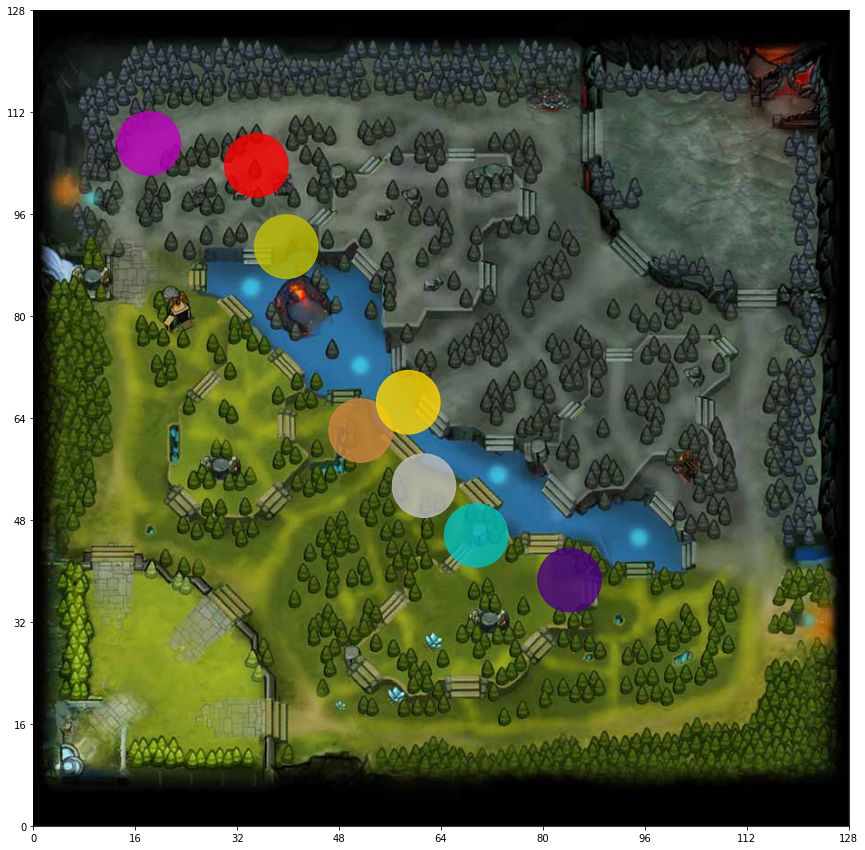

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

axs.imshow(img, extent=[0, 128, 0, 128])
plt.xticks(np.arange(0, 144, 16))
plt.yticks(np.arange(0, 144, 16))


for (x, y), color in zip(pairs, colors):
    axs.add_patch(plt.Circle(
        (
            x, 
            y,
            8.96,
        ), color=color, alpha=0.8
    )
                 )                 

plt.show()